## Autoencoder Code (Spectrograms only)

In [13]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../../") # Add the parent directory to the path
from utils.reproducibility import set_seed
set_seed(1)
import torch
import os
from utils.get_data import AVMNISTDataModule
import torch.nn as nn
import torch.optim as optim
from models.dino import SpectrogramEncoder
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from training_structures.dino_train import feature_extraction_loop, compute_gflops, \
                                           train_knn_classifier, compute_classification_metrics, train_downstream
from torchinfo import summary
import copy
import time
from utils.visualisations import pca_plot_dataloaders, pca_plot_multiclass, tsne_plot_multiclass, visualize_prediction_matrix

current_path = os.getcwd()
root_path = "../../"
data_dir=f'{root_path}/data/avmnist/'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
# Dataset definitions
current_path = os.getcwd()
# Set data loaders for evaluation
avmnist_data = AVMNISTDataModule(
    data_dir=data_dir, 
    num_workers=0, 
    batch_size=128,
)
avmnist_data.setup()
train_loader,valid_loader,test_loader = \
    avmnist_data.train_dataloader(), avmnist_data.val_dataloader(), avmnist_data.test_dataloader()

### Class definitions

In [15]:
class ConvAutoencoder(nn.Module):
    def __init__(self, output_dim=256):
        super().__init__()  # Use parent init

        self.output_dim = output_dim  # Dimension of the latent space
        
        # **Encoder**
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # (1, 112, 112) → (32, 56, 56)
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (64, 28, 28)
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (128, 14, 14)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # (256, 7, 7)
            nn.ReLU(),
            nn.Flatten(),  # (256*7*7)
            nn.Linear(256 * 7 * 7, output_dim)  # Project to latent_dim
        )

        # **Decoder**
        self.decoder = nn.Sequential(
            nn.Linear(output_dim, 256 * 7 * 7),  # Expand from latent space
            nn.ReLU(),
            nn.Unflatten(1, (256, 7, 7)),  # Reshape back to feature map
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  
            nn.Sigmoid()  # Output in range [0,1]
        )

    def forward(self, spectrograms):
        latent = self.encoder(spectrograms)
        reconstructed = self.decoder(latent)
        return reconstructed, latent  # Return both for further downstream use

In [16]:
def grouped_masking(spectrogram, mask_ratio=0.55, group_size=4):
    """
    Randomly masks groups of patches in the input spectrogram.
    
    Args:
        spectrogram: Input spectrogram of shape (batch_size, 1, height, width).
        mask_ratio: Fraction of the spectrogram to mask.
        group_size: Size of each group (e.g., 4x4 patches).
    
    Returns:
        masked_spectrogram: Spectrogram with masked regions set to 0.
        mask: Binary mask indicating the masked regions (1 = masked, 0 = unmasked).
    """
    batch_size, _, height, width = spectrogram.shape
    # print(f"Input spectrogram shape: {spectrogram.shape}")

    # Ensure height and width are divisible by group_size
    if height % group_size != 0 or width % group_size != 0:
        raise ValueError("Height and width must be divisible by group_size")

    # Reshape spectrogram into groups
    num_groups_h = height // group_size
    num_groups_w = width // group_size
    spectrogram = spectrogram.view(
        batch_size, 1,
        num_groups_h, group_size,
        num_groups_w, group_size
    )  # Shape: (batch_size, 1, num_groups_h, group_size, num_groups_w, group_size)
    # print(f"Spectrogram after grouping: {spectrogram.shape}")

    # Flatten the groups
    spectrogram = spectrogram.permute(0, 1, 2, 4, 3, 5).contiguous()
    spectrogram = spectrogram.view(batch_size, 1, num_groups_h * num_groups_w, group_size * group_size)
    # print(f"Spectrogram after flattening: {spectrogram.shape}")

    # Create a binary mask for groups
    num_groups = num_groups_h * num_groups_w
    num_masked_groups = int(mask_ratio * num_groups)
    mask = torch.ones(batch_size, num_groups, device=spectrogram.device)
    for i in range(batch_size):
        masked_indices = torch.randperm(num_groups)[:num_masked_groups]
        mask[i, masked_indices] = 0  # Set masked groups to 0

    # Reshape the mask to match the grouped spectrogram
    mask = mask.view(batch_size, num_groups_h, num_groups_w, 1)  # Shape: (batch_size, num_groups_h, num_groups_w, 1)
    mask = mask.unsqueeze(-1)  # Shape: (batch_size, num_groups_h, num_groups_w, 1, 1)
    mask = mask.unsqueeze(1)

    # Reshape the spectrogram to match the mask
    spectrogram = spectrogram.view(
        batch_size, 1,
        num_groups_h, num_groups_w,
        group_size, group_size
    )  # Shape: (batch_size, 1, num_groups_h, num_groups_w, group_size, group_size)

    # Apply the mask to the spectrogram
    masked_spectrogram = spectrogram * mask  # Broadcasting applies the mask correctly
    # print(f"Masked spectrogram before reshaping: {masked_spectrogram.shape}")

    # Reshape back to original spectrogram shape
    masked_spectrogram = masked_spectrogram.permute(0, 1, 2, 4, 3, 5).contiguous()
    masked_spectrogram = masked_spectrogram.view(batch_size, 1, height, width)
    # print(f"Final masked spectrogram shape: {masked_spectrogram.shape}")

    # Create the full binary mask for visualization or loss computation
    mask = mask.view(batch_size, num_groups_h, num_groups_w, 1)
    mask = mask.repeat(1, 1, 1, group_size * group_size)
    mask = mask.view(batch_size, num_groups_h * group_size, num_groups_w * group_size)
    mask = mask.view(batch_size, height, width)
    # print(f"Final mask shape: {mask.shape}")

    return masked_spectrogram, mask

Batch of images | image: torch.Size([128, 1, 28, 28]) | audio: torch.Size([128, 1, 112, 112]) | label: torch.Size([128])


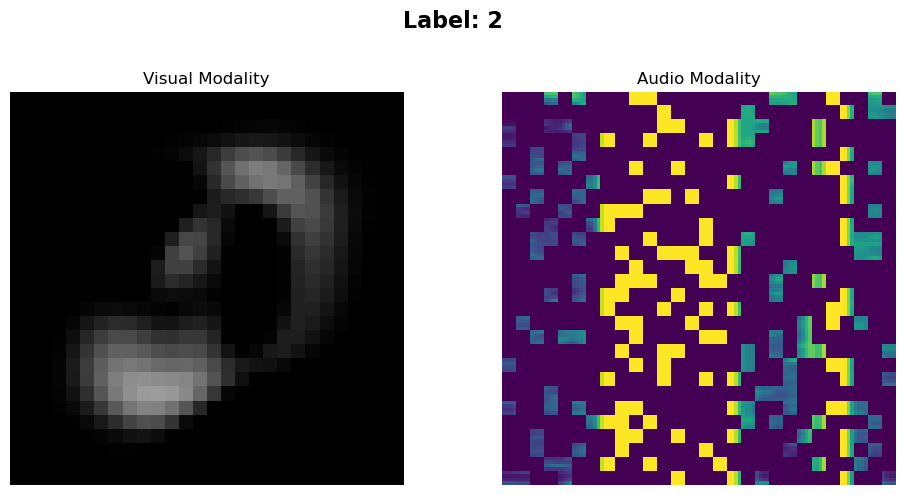

In [17]:
from utils.visualisations import show_images

for image, audio, label in train_loader:
    print(f"Batch of images | image: {image.shape} | audio: {audio.shape} | label: {label.shape}")
    idx = 1
    masked_spectrogram, mask = grouped_masking(audio[idx].unsqueeze(0), mask_ratio=0.75)
    show_images(image[idx], masked_spectrogram.squeeze(0), label[idx])
    break  # Test one batch

In [18]:
class MaskedConvAutoencoder(nn.Module):
    def __init__(self, output_dim=256, mask_ratio=0.75):
        super().__init__()
        self.output_dim = output_dim  # Dimension of the latent space
        self.mask_ratio = mask_ratio

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),  # (1, 112, 112) → (32, 56, 56)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (64, 28, 28)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # (128, 14, 14)
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # (256, 7, 7)
            nn.ReLU(),
            nn.Flatten(),  # (256*7*7)
            nn.Linear(256 * 7 * 7, output_dim)  # Project to latent dim
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(output_dim, 256 * 7 * 7),  # Expand from latent space
            nn.ReLU(),
            nn.Unflatten(1, (256, 7, 7)),  # Reshape back to feature map
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Output in range [0,1]
        )

    def forward(self, x):
        # Apply random masking
        masked_x, mask = grouped_masking(x, mask_ratio=self.mask_ratio)

        # Encode the masked input
        latent = self.encoder(masked_x)

        # Decode to reconstruct the full spectrogram
        reconstructed = self.decoder(latent)

        return reconstructed, mask

In [19]:
from torchvision.models.mobilenetv3 import mobilenet_v3_small

class MobileVitMaskedAutoencoder(nn.Module):
    def __init__(self, output_dim=256, mask_ratio=0.75):
        super().__init__()
        self.output_dim = output_dim  # Dimension of the latent space
        self.mask_ratio = mask_ratio
        self.mobile_net = mobilenet_v3_small(weights=None)
        # Modify first conv layer for single-channel input
        self.mobile_net.features[0][0] = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1, bias=False)
        # Remove classifier head and replace with projection layer
        self.mobile_net.classifier = nn.Identity()  # Remove MobileNet's original classifier
        # Projection layer with dropout
        self.projection = nn.Sequential(
            nn.Linear(576, 256),  # MobileNetV3 feature dim
            nn.ReLU(),
            nn.Linear(256, output_dim)  # Final embedding dim
        )

        # Encoder
        self.encoder = nn.Sequential(
            self.mobile_net,
            nn.Linear(576, 256),  # MobileNetV3 feature dim
            nn.ReLU(),
            nn.Linear(256, output_dim)  # Final embedding dim
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(output_dim, 256 * 7 * 7),  # Expand from latent space
            nn.ReLU(),
            nn.Unflatten(1, (256, 7, 7)),  # Reshape back to feature map
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Output in range [0,1]
        )

    def forward(self, x):
        # Apply random masking
        masked_x, mask = grouped_masking(x, mask_ratio=self.mask_ratio)

        # Encode the masked input
        latent = self.encoder(masked_x)

        # Decode to reconstruct the full spectrogram
        reconstructed = self.decoder(latent)

        return reconstructed, mask

In [20]:
class EncoderWrapper(nn.Module):
    """
    A wrapper for the encoder part of the autoencoder to be used for feature extraction.
    """
    def __init__(self, auto_encoder):
        super().__init__()
        self.encoder = auto_encoder.encoder
        self.output_dim = auto_encoder.output_dim  # Keep the output dimension

    def forward(self, images=None, spectrograms=None):
        if spectrograms is None:
            raise ValueError("Input spectrograms must be provided for feature extraction.")
        with torch.no_grad():
            features = self.encoder(spectrograms)
        return features

### Training code

In [21]:
def train_autoencoder(model, dataloader, epochs=50, lr=1e-3, device="cuda"):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for image, spectrograms, label in dataloader:
            spectrograms = spectrograms.float().to(device)  # Expecting (batch_size, 1, 112, 112)

            optimizer.zero_grad()
            reconstructed, _ = model(spectrograms=spectrograms)

            loss = criterion(reconstructed, spectrograms)  # Reconstruction loss
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")


In [22]:
def train_masked_autoencoder(model, dataloader, epochs=100, lr=1e-3, device="cuda"):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()  # Reconstruction loss

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for image, spectrograms, label in dataloader:
            spectrograms = spectrograms.float().to(device)

            # Forward pass
            reconstructed, mask = model(spectrograms)

            # Compute loss only for masked regions
            loss = criterion(reconstructed * mask.unsqueeze(1), spectrograms * mask.unsqueeze(1))

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

### Model Training

In [23]:
def training_loop(auto_encoder, seeds=[1, 2, 3], model_name="autoencoder", epochs=100, train_fn=None):

    if train_fn is None:
        raise ValueError("Please provide a training function.")

    initial_model_weights = copy.deepcopy(auto_encoder.state_dict())

    gflops, params = compute_gflops(
        model = auto_encoder, 
        input_data = [
            torch.randn(1, 1, 112, 112),   # spectrograms (modality 2)
        ]
    )

    test_accuracies_knn = []
    test_accuracies_mlp = []
    training_times = []

    for seed in seeds:
        print(f"Training with seed {seed}...")
        set_seed(seed)
        auto_encoder.load_state_dict(copy.deepcopy(initial_model_weights))

         # Start training timer
        training_start = time.time()

        train_fn(auto_encoder, train_loader, epochs=epochs, lr=1e-3, device=device)

        # Calculate total training time
        training_time = time.time() - training_start
        
        encoder = EncoderWrapper(auto_encoder)
        _, knn_accuracy = train_knn_classifier(encoder, train_loader, test_loader, n_neighbors=5, device=device, is_dino_based=False)
        mlp_classifier = train_downstream(
            encoder,
            train_loader,
            valid_loader,
            test_loader,
            num_epochs=10,
            device=device,
            save_path=f'results/{model_name}/{model_name}_seed_{seed}.pt',
            train_log_path=f'results/{model_name}/{model_name}_seed_{seed}_train_log.csv',
            test_log_path=f'results/{model_name}/{model_name}_seed_{seed}_test_log.csv',
            is_dino_based=False,
        )
        mlp_accuracy = compute_classification_metrics(mlp_classifier, test_loader, device)['accuracy']
        test_accuracies_knn.append(knn_accuracy)
        test_accuracies_mlp.append(mlp_accuracy)
        training_times.append(training_time)

    knn_acc = np.mean(test_accuracies_knn)
    mlp_acc = np.mean(test_accuracies_mlp)
    knn_acc_std = np.std(test_accuracies_knn)
    mlp_acc_std = np.std(test_accuracies_mlp)
    training_time = np.mean(training_times)
    
     # Also save a performance summary file
    perf_summary = {
        "model_name": model_name,
        "parameters": f"{params/1e6:.2f}M",
        "gflops": f"{gflops:.2f}",
        "seeds": seeds,
        "training_time_hours": f"{training_time/3600:.2f}",
        "downstream_mlp_acc": f"{mlp_acc:.4f}",
        "downstream_knn_accuracy": f"{knn_acc:.4f}",
        "downstream_mlp_acc_std": f"{mlp_acc_std:.4f}",
        "downstream_knn_accuracy_std": f"{knn_acc_std:.4f}",
    }

    with open(os.path.join("results", f"{model_name}", f"{model_name}_performance_summary.txt"), "w") as f:
        for key, value in perf_summary.items():
            f.write(f"{key}: {value}\n")

    _ = pca_plot_dataloaders(encoder, test_loader, selected_digits=[5, 8], dirpath=f"results/{model_name}", 
                            show_plots=False, is_dino_based=False)
    _ = pca_plot_multiclass(encoder, test_loader, selected_digits=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
                            dirpath=f"results/{model_name}", show_plots=False, is_dino_based=False)
    _ = tsne_plot_multiclass(encoder, test_loader, selected_digits=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
                            dirpath=f"results/{model_name}", show_plots=False, random_seed=0, is_dino_based=False)
    _ = visualize_prediction_matrix(mlp_classifier, test_loader, dirpath=f"results/{model_name}", 
                                    show_plots=False)

In [ ]:
auto_encoder = ConvAutoencoder(output_dim=512)
training_loop(auto_encoder, seeds=[1, 2, 3], train_fn=train_autoencoder)

In [24]:
masked_autoencoder_mobilevit = MobileVitMaskedAutoencoder(output_dim=256, mask_ratio=0.75)
training_loop(masked_autoencoder_mobilevit, seeds=[1, 2, 3], model_name="masked_autoencoder_mobilevit", epochs=100, train_fn=train_masked_autoencoder)

Model GFLOPs: 0.20 GFLOPs
Model Parameters: 4.97 M parameters
Training with seed 1...
Epoch 1/100, Loss: 0.006971
Epoch 2/100, Loss: 0.002768
Epoch 3/100, Loss: 0.002324
Epoch 4/100, Loss: 0.002148
Epoch 5/100, Loss: 0.001986
Epoch 6/100, Loss: 0.001891
Epoch 7/100, Loss: 0.001819
Epoch 8/100, Loss: 0.001732
Epoch 9/100, Loss: 0.001685
Epoch 10/100, Loss: 0.001632
Epoch 11/100, Loss: 0.001568
Epoch 12/100, Loss: 0.001513
Epoch 13/100, Loss: 0.001486
Epoch 14/100, Loss: 0.001448
Epoch 15/100, Loss: 0.001405
Epoch 16/100, Loss: 0.001373
Epoch 17/100, Loss: 0.001355
Epoch 18/100, Loss: 0.001325
Epoch 19/100, Loss: 0.001297
Epoch 20/100, Loss: 0.001266
Epoch 21/100, Loss: 0.001254
Epoch 22/100, Loss: 0.001232
Epoch 23/100, Loss: 0.001214
Epoch 24/100, Loss: 0.001192
Epoch 25/100, Loss: 0.001174
Epoch 26/100, Loss: 0.001148
Epoch 27/100, Loss: 0.001135
Epoch 28/100, Loss: 0.001111
Epoch 29/100, Loss: 0.001098
Epoch 30/100, Loss: 0.001087
Epoch 31/100, Loss: 0.001065
Epoch 32/100, Loss: 0.00

100%|██████████| 430/430 [00:09<00:00, 43.60it/s]


Extracting test features...


100%|██████████| 79/79 [00:04<00:00, 17.29it/s]


Training KNN classifier...


c:\Users\Ward\Desktop\vub-github\Thesis-project\AVMNIST_Experiments\other_ssl\autoencoder\../..\training_structures\dino_train.py:229: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True) # For mixed precision training


KNN Accuracy (k=5): 25.1800%


Epoch 1/10: 100%|██████████| 430/430 [00:13<00:00, 33.07it/s, loss=1.81]


Epoch 1: Train Loss: 1.8624, Val Loss: 1.7405, Val Acc: 38.00%
Saved best model with validation accuracy: 38.00%


Epoch 2/10: 100%|██████████| 430/430 [00:11<00:00, 35.98it/s, loss=1.95]


Epoch 2: Train Loss: 1.7321, Val Loss: 1.7050, Val Acc: 39.54%
Saved best model with validation accuracy: 39.54%


Epoch 3/10: 100%|██████████| 430/430 [00:12<00:00, 35.58it/s, loss=1.79]


Epoch 3: Train Loss: 1.6847, Val Loss: 1.6852, Val Acc: 39.42%


Epoch 4/10: 100%|██████████| 430/430 [00:12<00:00, 35.20it/s, loss=1.59]


Epoch 4: Train Loss: 1.6532, Val Loss: 1.6681, Val Acc: 40.24%
Saved best model with validation accuracy: 40.24%


Epoch 5/10: 100%|██████████| 430/430 [00:12<00:00, 35.19it/s, loss=1.68]


Epoch 5: Train Loss: 1.6271, Val Loss: 1.6432, Val Acc: 40.74%
Saved best model with validation accuracy: 40.74%


Epoch 6/10: 100%|██████████| 430/430 [00:12<00:00, 35.11it/s, loss=1.93]


Epoch 6: Train Loss: 1.6013, Val Loss: 1.6312, Val Acc: 41.70%
Saved best model with validation accuracy: 41.70%


Epoch 7/10: 100%|██████████| 430/430 [00:12<00:00, 35.09it/s, loss=1.79]


Epoch 7: Train Loss: 1.5809, Val Loss: 1.6212, Val Acc: 41.62%


Epoch 8/10: 100%|██████████| 430/430 [00:11<00:00, 35.92it/s, loss=1.48]


Epoch 8: Train Loss: 1.5644, Val Loss: 1.6137, Val Acc: 42.10%
Saved best model with validation accuracy: 42.10%


Epoch 9/10: 100%|██████████| 430/430 [00:11<00:00, 35.85it/s, loss=1.47]


Epoch 9: Train Loss: 1.5511, Val Loss: 1.6125, Val Acc: 42.16%
Saved best model with validation accuracy: 42.16%


Epoch 10/10: 100%|██████████| 430/430 [00:12<00:00, 35.82it/s, loss=1.36]


Epoch 10: Train Loss: 1.5427, Val Loss: 1.6123, Val Acc: 42.08%


c:\Users\Ward\Desktop\vub-github\Thesis-project\AVMNIST_Experiments\other_ssl\autoencoder\../..\training_structures\dino_train.py:317: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental fea


Test Accuracy: 37.52%
Training with seed 2...
Epoch 1/100, Loss: 0.006904
Epoch 2/100, Loss: 0.002641


KeyboardInterrupt: 

In [ ]:
# Initialize the model
masked_autoencoder_conv = MaskedConvAutoencoder(output_dim=256, mask_ratio=0.75)
training_loop(masked_autoencoder_conv, seeds=[1, 2, 3], model_name="masked_autoencoder_conv", epochs=100, train_fn=train_masked_autoencoder)

Model GFLOPs: 0.23 GFLOPs
Model Parameters: 7.21 M parameters
Training with seed 1...
Epoch 1/100, Loss: 0.005044
Epoch 2/100, Loss: 0.001451
Epoch 3/100, Loss: 0.001207
Epoch 4/100, Loss: 0.001047
Epoch 5/100, Loss: 0.000934
Epoch 6/100, Loss: 0.000870
Epoch 7/100, Loss: 0.000822
Epoch 8/100, Loss: 0.000774
Epoch 9/100, Loss: 0.000737
Epoch 10/100, Loss: 0.000711
Epoch 11/100, Loss: 0.000687
Epoch 12/100, Loss: 0.000668
Epoch 13/100, Loss: 0.000655
Epoch 14/100, Loss: 0.000639
Epoch 15/100, Loss: 0.000625
Epoch 16/100, Loss: 0.000613
Epoch 17/100, Loss: 0.000603
Epoch 18/100, Loss: 0.000593
Epoch 19/100, Loss: 0.000584
Epoch 20/100, Loss: 0.000576
Epoch 21/100, Loss: 0.000568
Epoch 22/100, Loss: 0.000560
Epoch 23/100, Loss: 0.000556
Epoch 24/100, Loss: 0.000550
Epoch 25/100, Loss: 0.000545
Epoch 26/100, Loss: 0.000539
Epoch 27/100, Loss: 0.000534
Epoch 28/100, Loss: 0.000528
Epoch 29/100, Loss: 0.000523
Epoch 30/100, Loss: 0.000521
Epoch 31/100, Loss: 0.000518
Epoch 32/100, Loss: 0.00

100%|██████████| 430/430 [00:09<00:00, 46.90it/s]


Extracting test features...


100%|██████████| 79/79 [00:01<00:00, 42.45it/s]


Training KNN classifier...


c:\Users\Ward\Desktop\vub-github\Thesis-project\AVMNIST_Experiments\other_ssl\autoencoder\../..\training_structures\dino_train.py:197: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True) # For mixed precision training


KNN Accuracy (k=5): 30.3200%


Epoch 1/10: 100%|██████████| 430/430 [00:09<00:00, 44.66it/s, loss=0.874]


Epoch 1: Train Loss: 0.9946, Val Loss: 0.7267, Val Acc: 75.70%
Saved best model with validation accuracy: 75.70%


Epoch 2/10: 100%|██████████| 430/430 [00:10<00:00, 42.75it/s, loss=0.829]


Epoch 2: Train Loss: 0.6784, Val Loss: 0.6268, Val Acc: 78.66%
Saved best model with validation accuracy: 78.66%


Epoch 3/10: 100%|██████████| 430/430 [00:10<00:00, 42.67it/s, loss=0.59] 


Epoch 3: Train Loss: 0.5824, Val Loss: 0.5736, Val Acc: 80.92%
Saved best model with validation accuracy: 80.92%


Epoch 4/10: 100%|██████████| 430/430 [00:09<00:00, 43.07it/s, loss=0.565]


Epoch 4: Train Loss: 0.5128, Val Loss: 0.5234, Val Acc: 82.92%
Saved best model with validation accuracy: 82.92%


Epoch 5/10: 100%|██████████| 430/430 [00:09<00:00, 43.06it/s, loss=0.494]


Epoch 5: Train Loss: 0.4589, Val Loss: 0.4951, Val Acc: 83.02%
Saved best model with validation accuracy: 83.02%


Epoch 6/10: 100%|██████████| 430/430 [00:09<00:00, 43.13it/s, loss=0.554]


Epoch 6: Train Loss: 0.4169, Val Loss: 0.4795, Val Acc: 83.82%
Saved best model with validation accuracy: 83.82%


Epoch 7/10: 100%|██████████| 430/430 [00:10<00:00, 41.64it/s, loss=0.47] 


Epoch 7: Train Loss: 0.3852, Val Loss: 0.4643, Val Acc: 83.90%
Saved best model with validation accuracy: 83.90%


Epoch 8/10: 100%|██████████| 430/430 [00:10<00:00, 42.31it/s, loss=0.338]


Epoch 8: Train Loss: 0.3618, Val Loss: 0.4574, Val Acc: 84.52%
Saved best model with validation accuracy: 84.52%


Epoch 9/10: 100%|██████████| 430/430 [00:10<00:00, 42.46it/s, loss=0.397]


Epoch 9: Train Loss: 0.3466, Val Loss: 0.4524, Val Acc: 84.90%
Saved best model with validation accuracy: 84.90%


Epoch 10/10: 100%|██████████| 430/430 [00:10<00:00, 41.77it/s, loss=0.433]


Epoch 10: Train Loss: 0.3376, Val Loss: 0.4508, Val Acc: 84.76%


c:\Users\Ward\Desktop\vub-github\Thesis-project\AVMNIST_Experiments\other_ssl\autoencoder\../..\training_structures\dino_train.py:285: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental fea


Test Accuracy: 80.61%
Training with seed 2...
Epoch 1/100, Loss: 0.005104
Epoch 2/100, Loss: 0.001461
Epoch 3/100, Loss: 0.001202
Epoch 4/100, Loss: 0.001027
Epoch 5/100, Loss: 0.000926
Epoch 6/100, Loss: 0.000854
Epoch 7/100, Loss: 0.000800
Epoch 8/100, Loss: 0.000757
Epoch 9/100, Loss: 0.000723
Epoch 10/100, Loss: 0.000699
Epoch 11/100, Loss: 0.000677
Epoch 12/100, Loss: 0.000660
Epoch 13/100, Loss: 0.000648
Epoch 14/100, Loss: 0.000631
Epoch 15/100, Loss: 0.000621
Epoch 16/100, Loss: 0.000607
Epoch 17/100, Loss: 0.000594
Epoch 18/100, Loss: 0.000587
Epoch 19/100, Loss: 0.000580
Epoch 20/100, Loss: 0.000570
Epoch 21/100, Loss: 0.000560
Epoch 22/100, Loss: 0.000556
Epoch 23/100, Loss: 0.000549
Epoch 24/100, Loss: 0.000543
Epoch 25/100, Loss: 0.000538
Epoch 26/100, Loss: 0.000535
Epoch 27/100, Loss: 0.000527
Epoch 28/100, Loss: 0.000522
Epoch 29/100, Loss: 0.000517
Epoch 30/100, Loss: 0.000515
Epoch 31/100, Loss: 0.000509
Epoch 32/100, Loss: 0.000505
Epoch 33/100, Loss: 0.000501
Epoch

100%|██████████| 430/430 [00:10<00:00, 42.28it/s]


Extracting test features...


100%|██████████| 79/79 [00:01<00:00, 42.02it/s]


Training KNN classifier...


c:\Users\Ward\Desktop\vub-github\Thesis-project\AVMNIST_Experiments\other_ssl\autoencoder\../..\training_structures\dino_train.py:197: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True) # For mixed precision training


KNN Accuracy (k=5): 28.4900%


Epoch 1/10: 100%|██████████| 430/430 [00:09<00:00, 43.18it/s, loss=0.808]


Epoch 1: Train Loss: 1.0104, Val Loss: 0.7238, Val Acc: 75.10%
Saved best model with validation accuracy: 75.10%


Epoch 2/10: 100%|██████████| 430/430 [00:10<00:00, 40.28it/s, loss=0.709]


Epoch 2: Train Loss: 0.6803, Val Loss: 0.6222, Val Acc: 79.42%
Saved best model with validation accuracy: 79.42%


Epoch 3/10: 100%|██████████| 430/430 [00:10<00:00, 40.50it/s, loss=0.649]


Epoch 3: Train Loss: 0.5848, Val Loss: 0.5670, Val Acc: 81.12%
Saved best model with validation accuracy: 81.12%


Epoch 4/10: 100%|██████████| 430/430 [00:10<00:00, 39.79it/s, loss=0.508]


Epoch 4: Train Loss: 0.5125, Val Loss: 0.5222, Val Acc: 82.24%
Saved best model with validation accuracy: 82.24%


Epoch 5/10: 100%|██████████| 430/430 [00:10<00:00, 42.24it/s, loss=0.311]


Epoch 5: Train Loss: 0.4573, Val Loss: 0.4903, Val Acc: 83.16%
Saved best model with validation accuracy: 83.16%


Epoch 6/10: 100%|██████████| 430/430 [00:10<00:00, 41.35it/s, loss=0.335]


Epoch 6: Train Loss: 0.4150, Val Loss: 0.4751, Val Acc: 83.90%
Saved best model with validation accuracy: 83.90%


Epoch 7/10: 100%|██████████| 430/430 [00:10<00:00, 40.94it/s, loss=0.438]


Epoch 7: Train Loss: 0.3830, Val Loss: 0.4589, Val Acc: 84.26%
Saved best model with validation accuracy: 84.26%


Epoch 8/10: 100%|██████████| 430/430 [00:11<00:00, 38.96it/s, loss=0.373]


Epoch 8: Train Loss: 0.3590, Val Loss: 0.4540, Val Acc: 84.78%
Saved best model with validation accuracy: 84.78%


Epoch 9/10: 100%|██████████| 430/430 [00:09<00:00, 46.26it/s, loss=0.306]


Epoch 9: Train Loss: 0.3433, Val Loss: 0.4477, Val Acc: 84.88%
Saved best model with validation accuracy: 84.88%


Epoch 10/10: 100%|██████████| 430/430 [00:09<00:00, 43.86it/s, loss=0.291]


Epoch 10: Train Loss: 0.3343, Val Loss: 0.4468, Val Acc: 85.08%
Saved best model with validation accuracy: 85.08%


c:\Users\Ward\Desktop\vub-github\Thesis-project\AVMNIST_Experiments\other_ssl\autoencoder\../..\training_structures\dino_train.py:285: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental fea


Test Accuracy: 81.03%
Training with seed 3...
Epoch 1/100, Loss: 0.004788
Epoch 2/100, Loss: 0.001441
Epoch 3/100, Loss: 0.001177
Epoch 4/100, Loss: 0.001020
Epoch 5/100, Loss: 0.000925
Epoch 6/100, Loss: 0.000862
Epoch 7/100, Loss: 0.000811
Epoch 8/100, Loss: 0.000765
Epoch 9/100, Loss: 0.000732
Epoch 10/100, Loss: 0.000706
Epoch 11/100, Loss: 0.000680
Epoch 12/100, Loss: 0.000662
Epoch 13/100, Loss: 0.000644
Epoch 14/100, Loss: 0.000629
Epoch 15/100, Loss: 0.000613
Epoch 16/100, Loss: 0.000602
Epoch 17/100, Loss: 0.000594
Epoch 18/100, Loss: 0.000582
Epoch 19/100, Loss: 0.000577
Epoch 20/100, Loss: 0.000566
Epoch 21/100, Loss: 0.000562
Epoch 22/100, Loss: 0.000554
Epoch 23/100, Loss: 0.000548
Epoch 24/100, Loss: 0.000542
Epoch 25/100, Loss: 0.000537
Epoch 26/100, Loss: 0.000532
Epoch 27/100, Loss: 0.000528
Epoch 28/100, Loss: 0.000523
Epoch 29/100, Loss: 0.000518
Epoch 30/100, Loss: 0.000513
Epoch 31/100, Loss: 0.000509
Epoch 32/100, Loss: 0.000506
Epoch 33/100, Loss: 0.000502
Epoch

100%|██████████| 430/430 [00:08<00:00, 48.74it/s]


Extracting test features...


100%|██████████| 79/79 [00:01<00:00, 44.08it/s]


Training KNN classifier...


c:\Users\Ward\Desktop\vub-github\Thesis-project\AVMNIST_Experiments\other_ssl\autoencoder\../..\training_structures\dino_train.py:197: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=True) # For mixed precision training


KNN Accuracy (k=5): 30.6200%


Epoch 1/10: 100%|██████████| 430/430 [00:09<00:00, 45.21it/s, loss=0.676]


Epoch 1: Train Loss: 0.9978, Val Loss: 0.7293, Val Acc: 75.54%
Saved best model with validation accuracy: 75.54%


Epoch 2/10: 100%|██████████| 430/430 [00:10<00:00, 41.99it/s, loss=0.881]


Epoch 2: Train Loss: 0.6748, Val Loss: 0.6310, Val Acc: 78.98%
Saved best model with validation accuracy: 78.98%


Epoch 3/10: 100%|██████████| 430/430 [00:10<00:00, 42.15it/s, loss=0.603]


Epoch 3: Train Loss: 0.5804, Val Loss: 0.5675, Val Acc: 80.52%
Saved best model with validation accuracy: 80.52%


Epoch 4/10: 100%|██████████| 430/430 [00:10<00:00, 41.89it/s, loss=0.396]


Epoch 4: Train Loss: 0.5114, Val Loss: 0.5304, Val Acc: 82.20%
Saved best model with validation accuracy: 82.20%


Epoch 5/10: 100%|██████████| 430/430 [00:10<00:00, 41.01it/s, loss=0.54] 


Epoch 5: Train Loss: 0.4581, Val Loss: 0.4972, Val Acc: 83.42%
Saved best model with validation accuracy: 83.42%


Epoch 6/10: 100%|██████████| 430/430 [00:10<00:00, 40.97it/s, loss=0.41] 


Epoch 6: Train Loss: 0.4173, Val Loss: 0.4797, Val Acc: 83.72%
Saved best model with validation accuracy: 83.72%


Epoch 7/10: 100%|██████████| 430/430 [00:10<00:00, 41.02it/s, loss=0.579]


Epoch 7: Train Loss: 0.3865, Val Loss: 0.4636, Val Acc: 84.10%
Saved best model with validation accuracy: 84.10%


Epoch 8/10: 100%|██████████| 430/430 [00:10<00:00, 41.22it/s, loss=0.446]


Epoch 8: Train Loss: 0.3636, Val Loss: 0.4605, Val Acc: 84.58%
Saved best model with validation accuracy: 84.58%


Epoch 9/10: 100%|██████████| 430/430 [00:10<00:00, 41.38it/s, loss=0.299]


Epoch 9: Train Loss: 0.3480, Val Loss: 0.4560, Val Acc: 84.32%


Epoch 10/10: 100%|██████████| 430/430 [00:10<00:00, 41.28it/s, loss=0.363]


Epoch 10: Train Loss: 0.3393, Val Loss: 0.4542, Val Acc: 84.34%


c:\Users\Ward\Desktop\vub-github\Thesis-project\AVMNIST_Experiments\other_ssl\autoencoder\../..\training_structures\dino_train.py:285: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental fea


Test Accuracy: 80.38%


100%|██████████| 79/79 [00:01<00:00, 66.67it/s]


Selected digits for visualization: [5, 8]


100%|██████████| 79/79 [00:01<00:00, 58.52it/s]


Visualizing digits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


100%|██████████| 79/79 [00:01<00:00, 67.87it/s]
c:\Users\Ward\anaconda3\envs\multibench\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


Visualizing digits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Applying t-SNE...


c:\Users\Ward\Desktop\vub-github\Thesis-project\AVMNIST_Experiments\other_ssl\autoencoder\../..\utils\visualisations.py:750: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
